In [4]:
import scanpy as sc
import numpy as np
import torch

import os,sys
pwd = '/home/lijiahao/workbench/sc-save/'
sys.path.append(pwd)
os.chdir(pwd)

from model.save_model import SAVE
from model.utils.process_h5ad import batch_scale, preprocessing_rna

In [5]:
device = torch.device('cuda:0')
seed = 1202
kwargs = {
    "device": device,
    "seed": seed,
    "is_ret_val": True,
    "is_ret_raw": True,
    "is_val_pca": False,
    "is_ret_model": False,
    "is_data_scaled": True,
}
import yaml

with open(pwd + "/model_setting.yml", "r") as f:
    setting = yaml.safe_load(f)

kwargs.update(setting["SAVE-B"]["train"])
kwargs.update(setting["SAVE-B"]["model"])

# for prior integration method
kwargs["is_ret_val"] = False
kwargs["is_ret_model"] = True
kwargs["is_data_scaled"] = True


In [6]:
adata = sc.read_h5ad('/home/lijiahao/workbench/sc-save/data/rna_drop/5_5_drop.h5ad')

In [9]:
adata.obs['batch'] = '5_5'

In [12]:
adata = preprocessing_rna(adata, is_batch_scale=True, min_features=0, min_cells=0)

/home/lijiahao/miniconda3/envs/save-stable/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
batch_scale: 100%|████████████████████████████████| 1/1 [00:00<00:00, 14.19it/s]


In [13]:

from model.save_model import SAVE

save_model = SAVE(
    adata=adata.copy(),
    is_initialized=True,
    condition_cols=['batch'],
    **kwargs,
    )
save_model.train(col_msk_threshold=-1, row_msk_threshold=None, **kwargs)

total col comb is: 1
initialze model weight with seed 1202
cond encoding max: 0 min:0
total iter: 3200


100%|█████| 1600/1600 [16:46<00:00,  1.59it/s, recon_loss=111.298,kl_loss=7.609]


In [14]:
save_model.save_ckpt('/home/lijiahao/workbench/sc-save/data/rna_drop/drop.pt')

save ckpt to /home/lijiahao/workbench/sc-save/data/rna_drop/drop.pt!


In [15]:
recon_val = save_model.get_recon(batch_size=128, latent_pos=0)

cond encoding max: 0 min:0


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 33.85it/s]


In [19]:
recon_data = sc.AnnData(recon_val, obs=adata.obs, var=adata.var)
recon_data.obs['batch'] = 'recon'

In [20]:
m = sc.concat([recon_data, adata])

/home/lijiahao/miniconda3/envs/save-stable/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/lijiahao/miniconda3/envs/save-stable/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/lijiahao/miniconda3/envs/save-stable/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


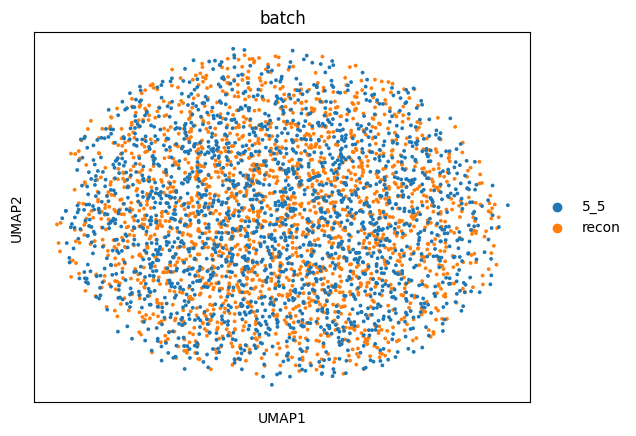

In [21]:
sc.pp.pca(m)
sc.pp.neighbors(m)
sc.tl.umap(m)
sc.pl.umap(m, color=['batch'])